In [89]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import numpy as np
import cv2
import torch
from MTL.model import resnet,MTL_model
import torchvision.transforms as transforms
from PIL import Image as im
import time

labels

In [91]:
emo={0:'sad', 1:'happy', 2:'angry', 3:'disgust', 4:'surprise', 5:'fear', 6:'neutral'}
gender={0:'man',1:'woman'}
age={0:'youth',1:'student',2:'adult',3:'elder'}

total_emo_dict={'sad':0,'happy':0,'angry':0,'disgust':0,'surprise':0,'fear':0,'neutral':0}
youth_emo_dict={'sad':0,'happy':0,'angry':0,'disgust':0,'surprise':0,'fear':0,'neutral':0}
student_emo_dict={'sad':0,'happy':0,'angry':0,'disgust':0,'surprise':0,'fear':0,'neutral':0}
adult_emo_dict={'sad':0,'happy':0,'angry':0,'disgust':0,'surprise':0,'fear':0,'neutral':0}
elder_emo_dict={'sad':0,'happy':0,'angry':0,'disgust':0,'surprise':0,'fear':0,'neutral':0}

man_emo_dict={'sad':0,'happy':0,'angry':0,'disgust':0,'surprise':0,'fear':0,'neutral':0}
woman_emo_dict={'sad':0,'happy':0,'angry':0,'disgust':0,'surprise':0,'fear':0,'neutral':0}

emo_labels=['sad','happy','angry','disgust','surprise','fear','neutral']
age_labels=['youth','student','adult','elder']
gender_labels=['man','woman']

prepare models

In [92]:
device='cuda:0'
model=YOLO('ultralytics/models/v8/yolov8s.yaml')
model=YOLO('weight/yolov8/s_best.pt')

multi_model=MTL_model.MultiTaskModel(phase='test')
wt=torch.load('weight/MTL/resnet18_5step_MTL_212.pt', map_location=torch.device('cuda:0'))
multi_model.load_state_dict(wt)
multi_model.to(device)



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.Conv                  [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.C2f                   [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.Conv                  [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.C2f                   [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.Conv                  [256

not pretrained model loaded


MultiTaskModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [93]:
results=[]
start_time=time.time()
result=model(source='asian.png')
orig_img=result[0].orig_img
img=Image.fromarray(orig_img)
numpy_img=np.array(img)
opencv_img=cv2.cvtColor(numpy_img,cv2.COLOR_BGR2RGB)
boxes=result[0].boxes.xyxy.cpu().numpy()





if len(boxes)==0:
    print('no boxes')
else:
    orig_img=cv2.cvtColor(orig_img,cv2.COLOR_BGR2RGB)
    orig_faces=[]
    for box in boxes:
        x1=int(box[0])
        y1=int(box[1])
        x2=int(box[2])
        y2=int(box[3])
        
        cv2.rectangle(opencv_img,(x1,y1),(x2,y2),(255,0,0),2)
        crop_img=orig_img[y1:y2,x1:x2,:]
        resized_img=cv2.resize(crop_img,(128,128))
        orig_faces.append(resized_img)

    faces=np.array(orig_faces).astype(np.float32)/255.0
    faces=np.transpose(faces,(0,3,1,2))
    faces=torch.from_numpy(faces)
    normalize=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    faces=normalize(faces)

    faces=faces.to(device)
    outputs=multi_model(faces)
    gender_output,emo_output,age_output=outputs
    gender_pred=gender_output.argmax(1,keepdim=True)
    emo_pred=emo_output.argmax(1,keepdim=True)
    age_pred=age_output.argmax(1,keepdim=True)
    results.append([gender_pred,emo_pred,age_pred])
    
end_time=time.time()

    




image 1/1 /home/joowan/Desktop/face_pr/asian.png: 224x640 20 faces, 5.8ms
Speed: 0.2ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


In [94]:
print(end_time-start_time)
print(len(boxes))

0.20628666877746582
20


In [95]:

for i in range(len(orig_faces)):
    emotion=emo[emo_pred[i].item()]
    ages=age[age_pred[i].item()]
    genders=gender[gender_pred[i].item()]
    total_emo_dict[emo[emo_pred[i].item()]]+=1
    
    if ages == 'youth':
        youth_emo_dict[emotion]+=1
    elif ages=='student':
        student_emo_dict[emotion]+=1
    elif ages=='adult':
        adult_emo_dict[emotion]+=1
    else:
        elder_emo_dict[emotion]+=1
        
    if genders=='man':
        man_emo_dict[emotion]+=1
    else:
        woman_emo_dict[emotion]+=1
        
    
total_emo_ratio=list(total_emo_dict.values())
youth_emo_ratio=list(youth_emo_dict.values())
student_emo_ratio=list(student_emo_dict.values())
adult_emo_ratio=list(adult_emo_dict.values())
elder_emo_ratio=list(elder_emo_dict.values())
man_emo_ratio=list(man_emo_dict.values())
woman_emo_ratio=list(woman_emo_dict.values())


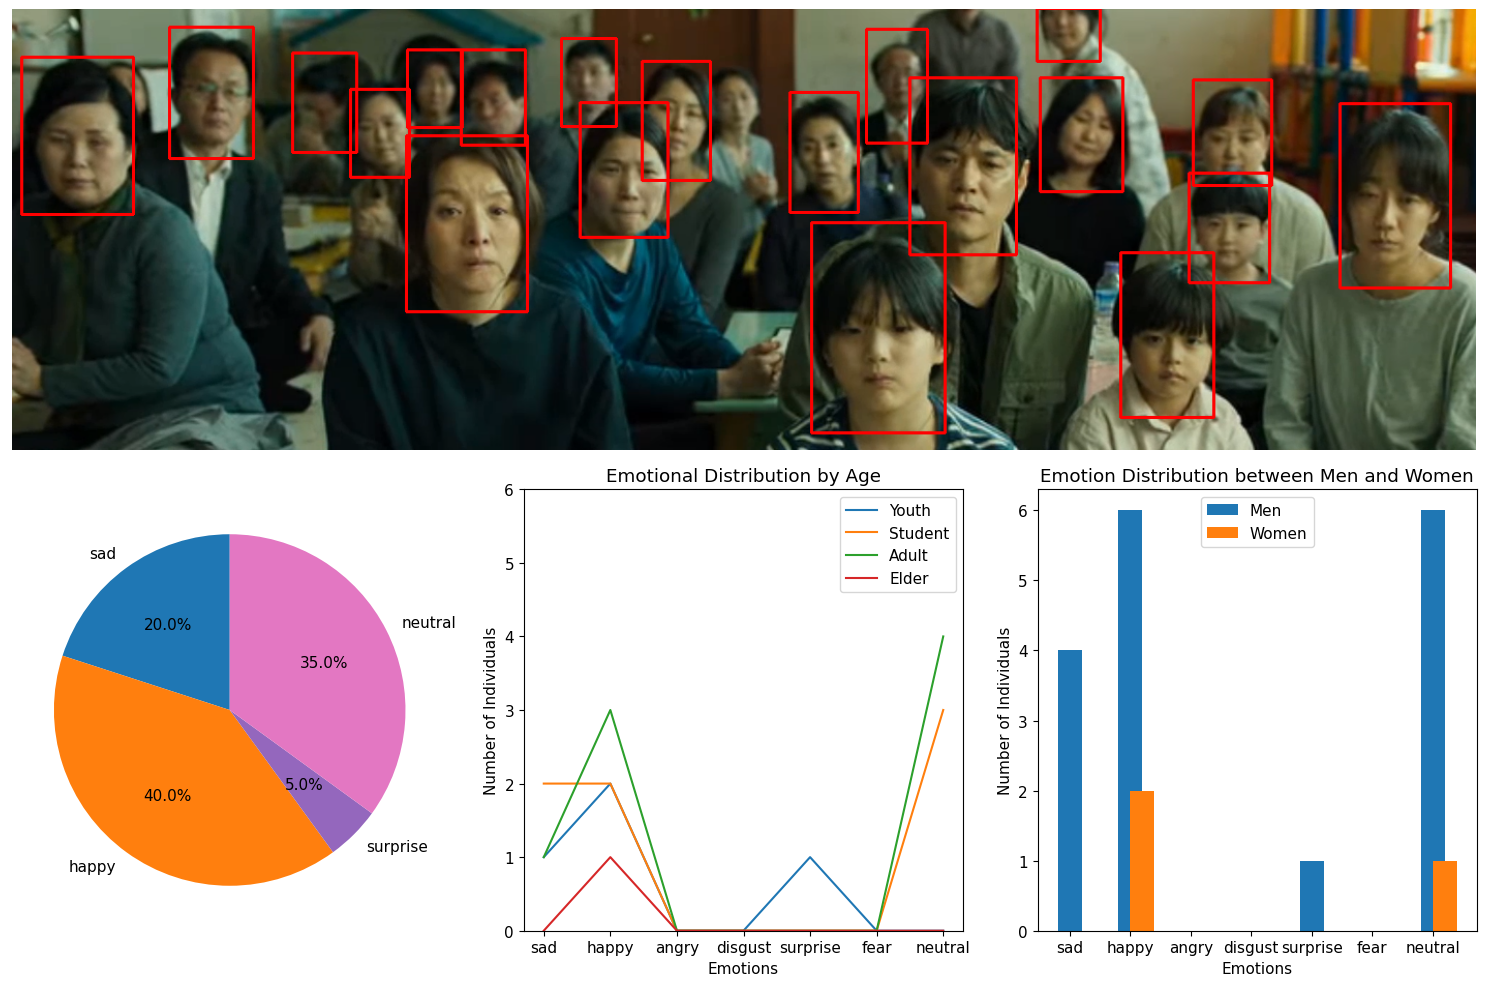

In [99]:
# Create subplots
fig = plt.figure(figsize=(15,10))
gs=gridspec.GridSpec(2,3)


ax1=plt.subplot(gs[0,:])
ax1.imshow(opencv_img)
ax1.axis('off')
# axs[0,1].axis('off')
# axs[0,2].axis('off')

# fig.delaxes(axs[0][1])
# fig.delaxes(axs[0][2]
#             )

# Plot the pie chart
ax2=plt.subplot(gs[1,0])
wedges1, texts1, autotexts1 = ax2.pie(total_emo_ratio, labels=emo_labels, autopct=lambda x: '{:.1f}%'.format(x) if x > 0 else '', startangle=90)
for i, text in enumerate(texts1):
    if total_emo_ratio[i] == 0:
        text.set_text('')

# Plot the line graph
ax3=plt.subplot(gs[1,1])
ax3.plot(emo_labels, youth_emo_ratio, label='Youth')
ax3.plot(emo_labels, student_emo_ratio, label='Student')
ax3.plot(emo_labels, adult_emo_ratio, label='Adult')
ax3.plot(emo_labels, elder_emo_ratio, label='Elder')
ax3.set_ylim(0, 6)
ax3.set_xlabel('Emotions')
ax3.set_ylabel('Number of Individuals')
ax3.set_title('Emotional Distribution by Age')
ax3.legend()

# Set the x positions of the bars
ax4=plt.subplot(gs[1,2])
x = range(len(emo_labels))

# Plotting
ax4.bar(x, man_emo_ratio, width=0.4, align='center', label='Men')
ax4.bar(x, woman_emo_ratio, width=0.4, align='edge', label='Women')

# Set the labels and title
ax4.set_xlabel('Emotions')
ax4.set_ylabel('Number of Individuals')
ax4.set_title('Emotion Distribution between Men and Women')

# Set the x-axis tick positions and labels
ax4.set_xticks(x, emo_labels)

# Add a legend
ax4.legend()

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

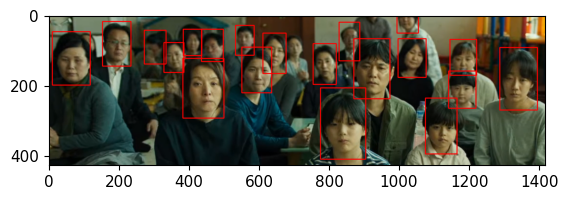

In [97]:
plt.imshow(opencv_img)
plt.show()